<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [ ]:
!pip install tensorflow
!pip install keras

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import time
import sklearn
import numpy as np
import random as rn
import pandas as pd
start_time = time.time()
from numpy import loadtxt
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split


# load das libs
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential
from keras.layers.embeddings import Embedding


# random state
sd = 5
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)
tf.random.set_seed(sd)

In [8]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [9]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [10]:
def preprocess(x):
    preprocess_x, x_tk = tokenize(x)

    preprocess_x = pad(preprocess_x)

    return preprocess_x, x_tk

In [11]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [12]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.show()
  
  
def plot_loss(history, miny=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

# Carrega base

In [26]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [ ]:
reviews = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA, index_col=0)
texto = reviews['text']
texto

In [40]:
text_tokenized, text_tokenizer = tokenize(texto)

test_pad = pad(text_tokenized)

y = reviews['label']

preproc_texto, texto_tokenizer = preprocess(texto)
    
max_text_length = preproc_texto.shape[1]
text_vocab_size = len(texto_tokenizer.word_index)

worddx = texto_tokenizer.word_index

print("Max sentence length:", max_text_length)
print("Vocabulary size:", text_vocab_size)

Max sentence length: 24
Vocabulary size: 9147


In [41]:
# parametros:
tam_vocab = text_vocab_size # vocabulário do embedding
tam_max = max_text_length # 100
batchsize = 64  # 64
embedding_dimen = 300  # 50 ! 300
filtros = 250 #250
kernel_size = 2 # 3 | 2
hidden_dims = 100 # not used
epochs = 100
lr = 0.0006 # 0.00006
drp = 0.4   # coeficiente de dropout

X_train, X_test, y_train, y_test = train_test_split(test_pad, y, test_size=0.3)

In [ ]:
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

embedding_layer = Embedding(tam_vocab, embedding_dimen, input_length=tam_max)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(100, 3, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(100, 3, activation="relu")(x)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(100, 3, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense(2, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
                                                                                              #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=1)

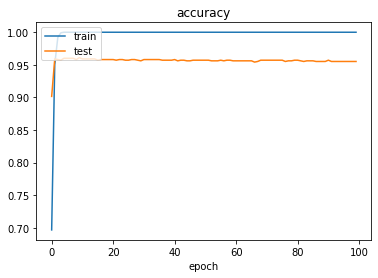

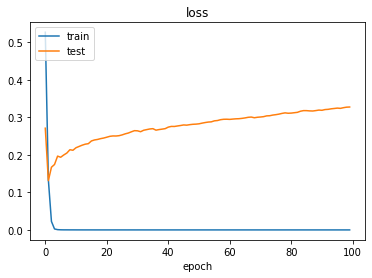

In [43]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [44]:
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

model = Sequential()
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())
model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(64, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 24, 300)           2744100   
                                                                 
 conv1d_25 (Conv1D)          (None, 22, 100)           90100     
                                                                 
 conv1d_26 (Conv1D)          (None, 20, 100)           30100     
                                                                 
 dropout_13 (Dropout)        (None, 20, 100)           0         
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 10, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 8, 100)            30100     
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 2s - loss: 1.2203 - accuracy: 0.5343 - val_loss: 0.6558 - val_accuracy: 0.6589 - 2s/epoch - 53ms/step
Epoch 2/100
38/38 - 0s - loss: 0.4036 - accuracy: 0.8154 - val_loss: 0.2838 - val_accuracy: 0.9152 - 291ms/epoch - 8ms/step
Epoch 3/100
38/38 - 0s - loss: 0.0791 - accuracy: 0.9741 - val_loss: 0.2415 - val_accuracy: 0.9142 - 270ms/epoch - 7ms/step
Epoch 4/100
38/38 - 0s - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.1863 - val_accuracy: 0.9376 - 277ms/epoch - 7ms/step
Epoch 5/100
38/38 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9327 - 273ms/epoch - 7ms/step
Epoch 6/100
38/38 - 0s - loss: 9.2387e-04 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.9366 - 276ms/epoch - 7ms/step
Epoch 7/100
38/38 - 0s - loss: 4.5972e-04 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.9347 - 272ms/epoch - 7ms/step
Epoch 8/100
38/38 - 0s - loss: 5.9681e-04 - accuracy: 1.0000 - val_loss: 0.2311 - val_accuracy: 0.9347 - 276ms/epoch - 7ms/step
Epoch 9/10

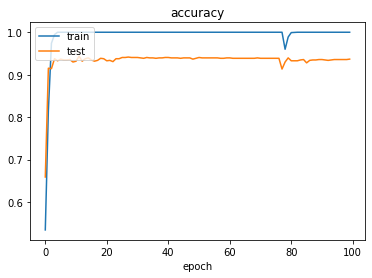

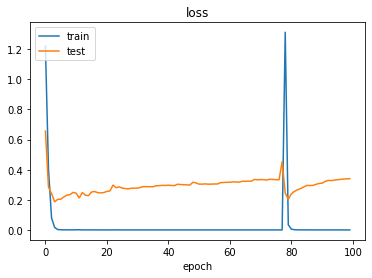

In [45]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [46]:
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate=lr,
#     decay_steps=10000,
#     decay_rate=0.9)

# https://keras.io/api/optimizers/
# https://keras.io/examples/nlp/pretrained_word_embeddings/
# https://keras.io/api/layers/base_layer/#layer-class

# optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") 
#optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
#optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
#optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
#optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

# # defininindo a camada de embedding utilizando a matriz
# embedding_layer = Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
#                             output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
#                             # weights=[MATRIZ_CBOW_300_BASE_2],
#                             embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
#                             input_length=tam_max,
#                             trainable=False)


model = Sequential()
# primeira camada se trata do embedding. 
# model.add(embedding_layer)
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# camada convolucional
# filtros referentes ao output dessa camada,
# tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# padding 'valid' = sem padding
# função de ativação = relu
model.add(Dropout(drp))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# camada convolucional                         'valid|same'
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# nivela o output para utilização na camada densa
model.add(Flatten())

# regularização por dropout
model.add(Dense(2, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 24, 300)           2744100   
                                                                 
 dropout_15 (Dropout)        (None, 24, 300)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 24, 250)           150250    
                                                                 
 conv1d_30 (Conv1D)          (None, 24, 250)           125250    
                                                                 
 dropout_16 (Dropout)        (None, 24, 250)           0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 12, 250)          0         
 g1D)                                                            
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 2s - loss: 0.5645 - accuracy: 0.6767 - val_loss: 0.3703 - val_accuracy: 0.8967 - 2s/epoch - 58ms/step
Epoch 2/100
38/38 - 0s - loss: 0.1916 - accuracy: 0.9390 - val_loss: 0.1792 - val_accuracy: 0.9493 - 331ms/epoch - 9ms/step
Epoch 3/100
38/38 - 0s - loss: 0.0550 - accuracy: 0.9825 - val_loss: 0.1294 - val_accuracy: 0.9630 - 323ms/epoch - 9ms/step
Epoch 4/100
38/38 - 0s - loss: 0.0152 - accuracy: 0.9971 - val_loss: 0.1190 - val_accuracy: 0.9620 - 333ms/epoch - 9ms/step
Epoch 5/100
38/38 - 0s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.1901 - val_accuracy: 0.9386 - 310ms/epoch - 8ms/step
Epoch 6/100
38/38 - 0s - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.1704 - val_accuracy: 0.9464 - 334ms/epoch - 9ms/step
Epoch 7/100
38/38 - 0s - loss: 0.0032 - accuracy: 0.9987 - val_loss: 0.2282 - val_accuracy: 0.9269 - 327ms/epoch - 9ms/step
Epoch 8/100
38/38 - 0s - loss: 0.0015 - accuracy: 0.9992 - val_loss: 0.1636 - val_accuracy: 0.9610 - 341ms/epoch - 9ms/step
Epoch 9/100
38/38 - 0s

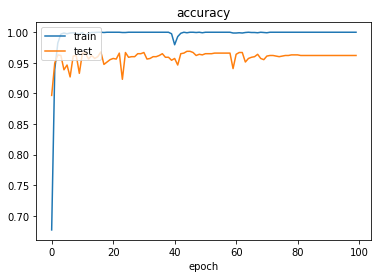

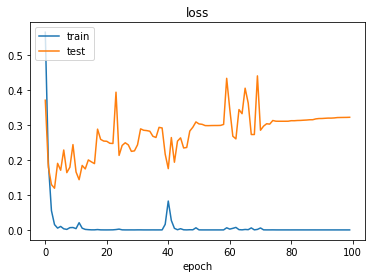

In [47]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

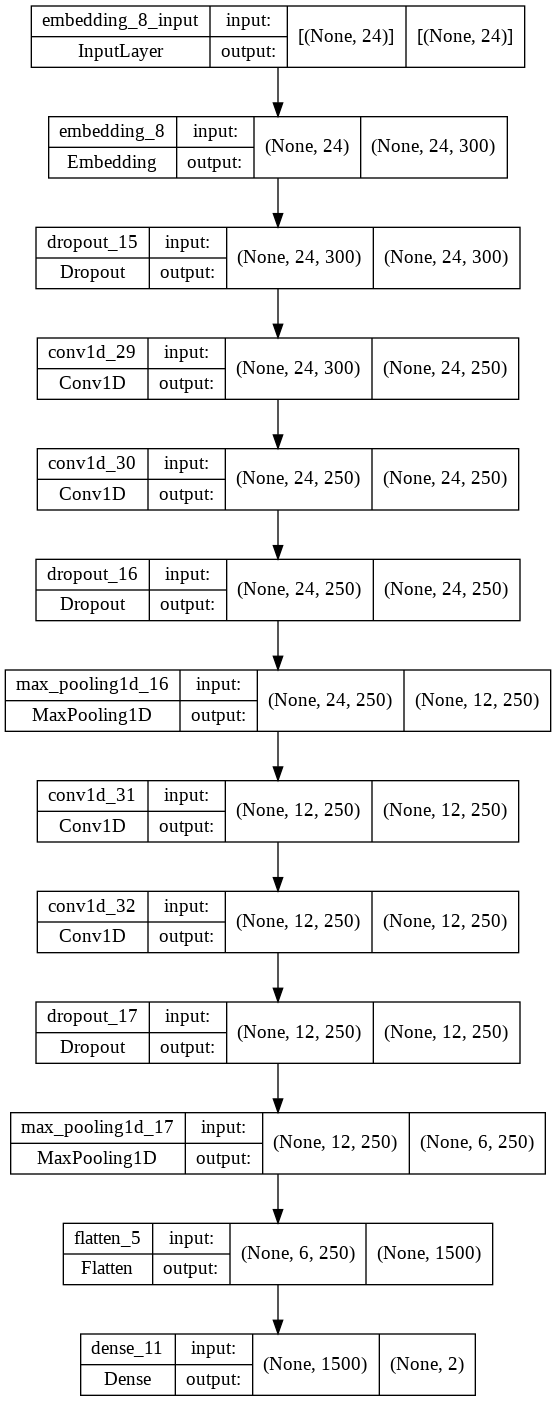

In [48]:
tf.keras.utils.plot_model(model, to_file='/meuarquivo.png', show_shapes=True)